In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [4]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from helpers import plots, evaluation, utils

## Load Model

In [5]:
model = load_model('../models/hggvgg_model_3.h5')
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 120, 120, 16)      64        
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
__________

## Load Data

In [7]:
batch_size = 16
SEED=42

X_valid_dir = '../data/np/X_test.npy'
X_seg_valid_dir = '../data/np/X_test_seg.npy'
y_valid_dir = '../data/np/y_test.npy'

X_test = load(X_valid_dir)
X_seg_test = load(X_seg_valid_dir)
y_test = load(y_valid_dir)
X_seg_test = np.expand_dims(X_seg_test, 3)

# y_test = np.array([[0,1] if x ==1 else [1,0] for x in y_test])

def get_generator(gen, classes=None):
    return gen.flow(X_test, y_test, batch_size=batch_size, shuffle=True, seed = SEED)

def get_seg_generator(gen, classes=None):                                            
    return gen.flow(X_seg_test, y_test, batch_size=batch_size, shuffle=True, seed = SEED)

val_gen = get_generator(ImageDataGenerator())
val_seg_gen = get_seg_generator(ImageDataGenerator())

[1. 0. 0. 0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


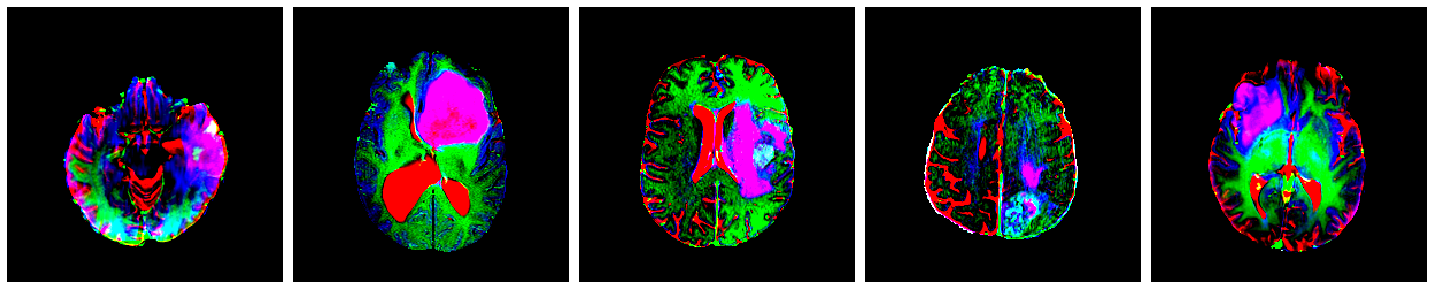

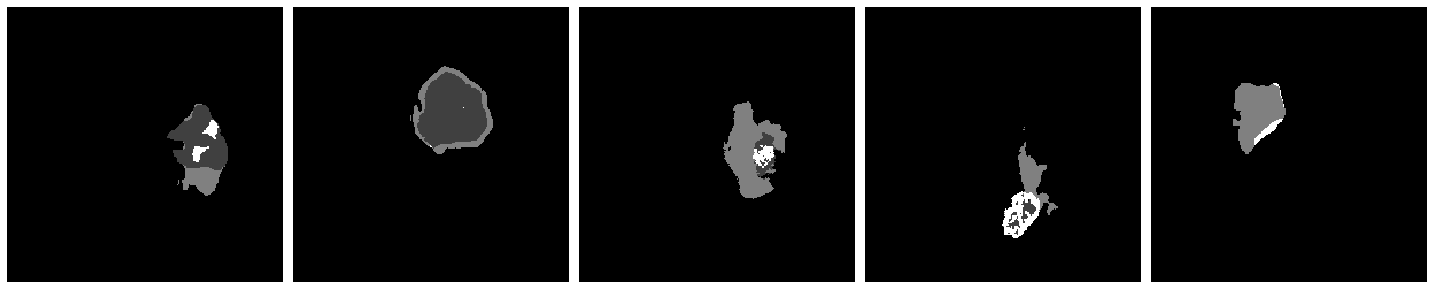

In [8]:
x, y = next(val_gen)
x_seg, y_seg = next(val_seg_gen)
print(y[:5])
plots.plot_rgb_images(x[:5])
plots.plot_gray_images(x_seg[:5])

## Define Analyzers

In [9]:
def bk_proj(X):
    X = ivis.clip_quantile(X, 1)
    return ivis.project(X)


def heatmap(X):
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)

methods = [
    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {}                       ,graymap,        "SmoothGrad"),
    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       bk_proj,        "Guided Backprop",),
    # Interaction
    ("input_t_gradient",      {},                       heatmap,        "Input * Gradient"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon")
]

# Create analyzers.
analyzers = []
for method in methods:
    print(method[3])
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    analyzers.append(analyzer)

Gradient
SmoothGrad
Deconvnet
Guided Backprop
Input * Gradient
LRP-Z
LRP-Epsilon


In [10]:
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = None
def postprocess(X, color_conversion, channels_first):
    X = X.copy()
    X = iutils.postprocess_images(
        X, color_coding=color_conversion, channels_first=channels_first)
    return X


n = 5
val_images, val_labels = next(val_gen)
test_images = list(zip(val_images[:n], val_labels[:n]))
label_to_class_name = { 0: '0', 1: '1'}

text = []
analysis = np.zeros([len(test_images), len(analyzers), 240, 240, 3])

for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        a = analyzer.analyze(x)
        a = postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        img = a[0]
        analysis[i, aidx] = img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

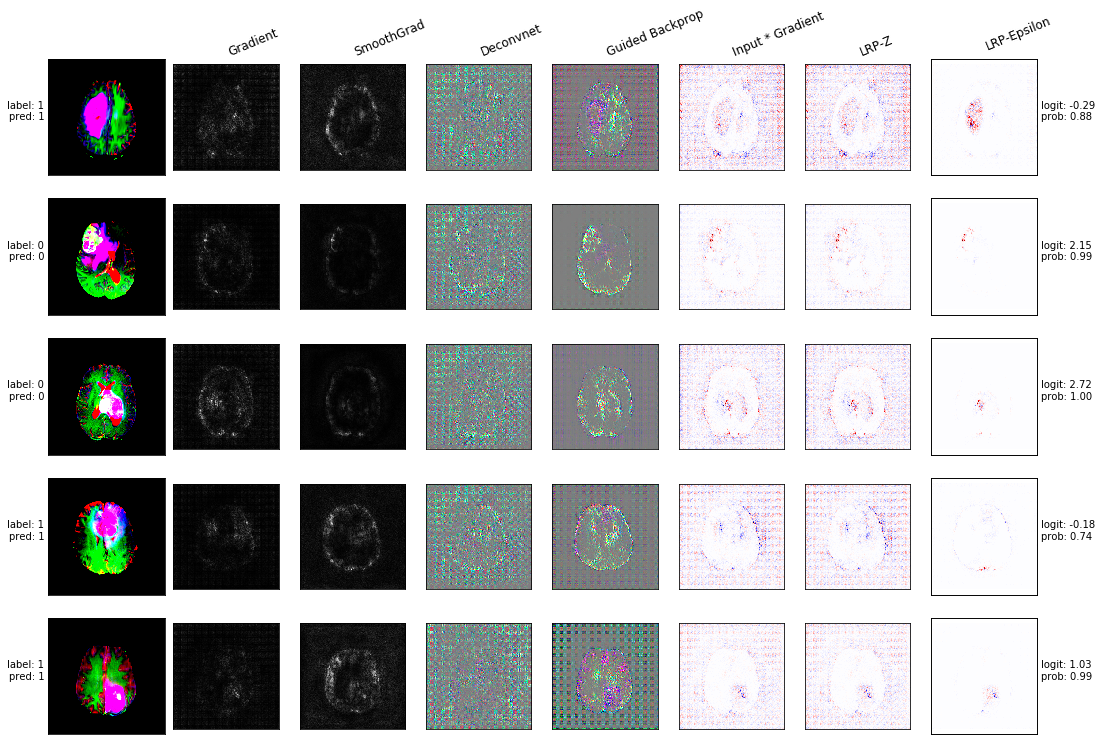

In [11]:
def get_label(l):
    return np.argmax(l)

# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# # Prepare the labels
label, presm, prob, pred = zip(*text)
# row_labels_left = [['label: {}'.format(l)] for l in val_labels[:n]]
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]
plots.plot_image_grid(val_images[:n],
                      grid,row_labels_left,
                      row_labels_right,
                      col_labels,figsize=(20,15))

# Evaluate interpretation

##### Create generator

As a first we will create generator for original images and images with segmentation of tumor

In [92]:
def image_mask_generator(gen, sgen, classes=None):
    return zip(get_generator(gen,classes=classes), get_seg_generator(sgen,classes=classes))

generator = image_mask_generator(ImageDataGenerator(), ImageDataGenerator())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


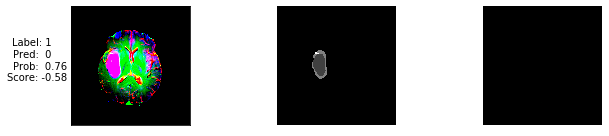

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


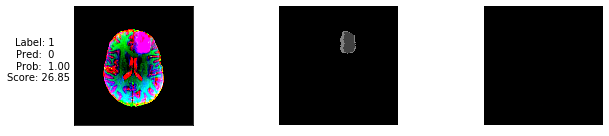

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


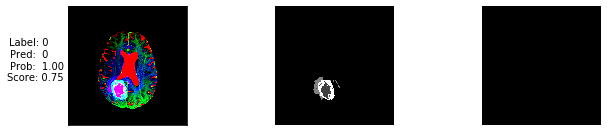

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


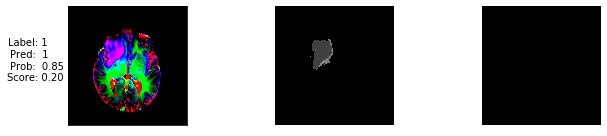

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


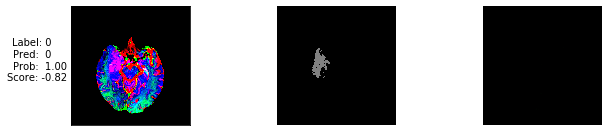

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


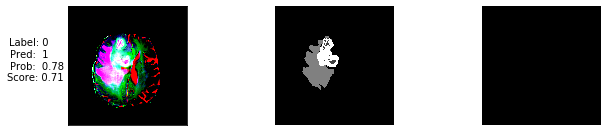

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


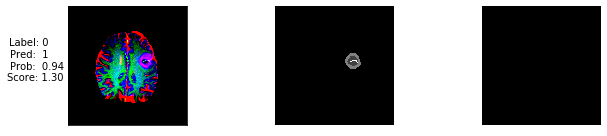

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


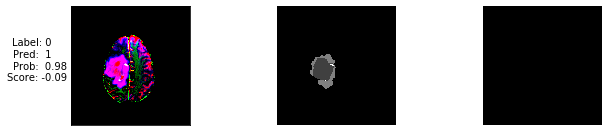

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


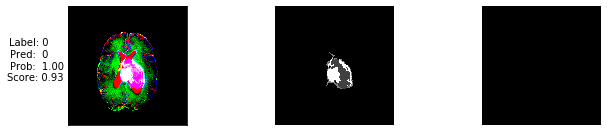

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


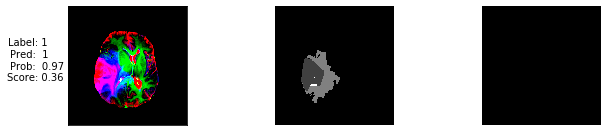

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


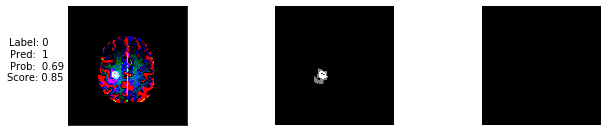

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


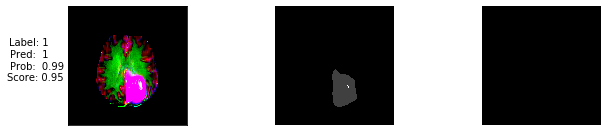

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


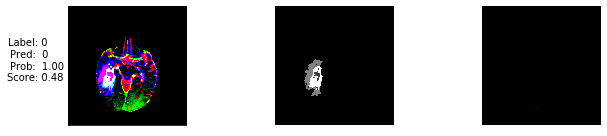

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


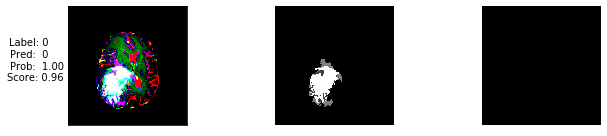

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


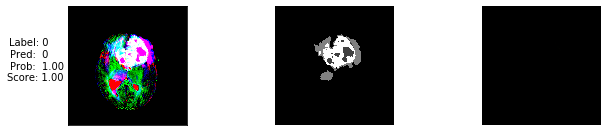

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


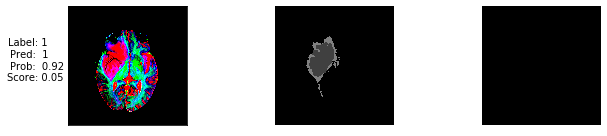

In [113]:
(x, y),(x_seg, y_seg) = next(generator)
evaluation.visualize_method(model, analyzer, x, x_seg, y)

##### Count metric

In second step we run mwntrics over analyzed images

In [77]:
metrics = evaluation.evaluate_method_generator(model, analyzers[0], generator, X_test.shape[0], batch_size)

In [78]:
(y, pred, prob, score) = np.stack(np.array(list(metrics)), axis=-1)

### Statistics

Lets plot some statistics obtained from metric

In [79]:
# (x,y),(x_seg, y_seg) = next(generator)
# evaluation.evaluate_method_visualize(model, analyzers[0], x, x_seg, y)

              1        0
mean:    |  0.51  |  0.54  |
std:     |  0.08  |  0.06  |
min:     |  0.32  |  0.28  |
max:     |  0.71  |  0.71  |
median:  |  0.52  |  0.54  |


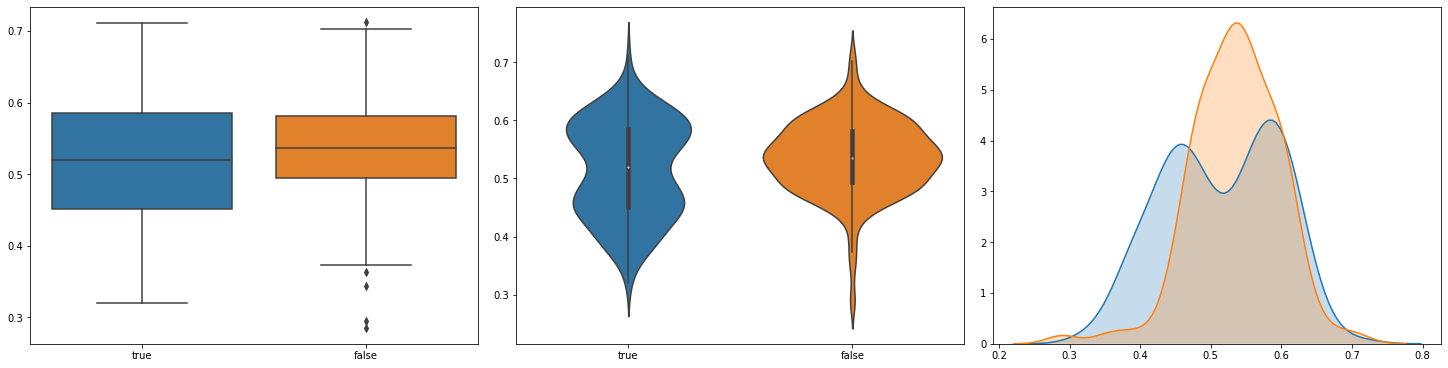

In [80]:
plots.plot_data_distribution(score[pred==1], score[pred==0])

#### Metrics for network prediction

Model performance:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83       196
         1.0       0.89      0.76      0.82       220

    accuracy                           0.82       416
   macro avg       0.83      0.83      0.82       416
weighted avg       0.83      0.82      0.82       416



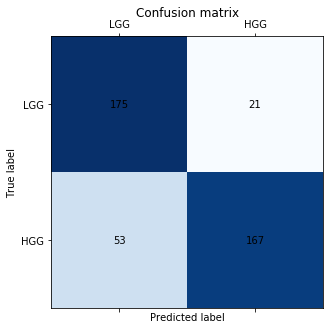

Analyzer performance:


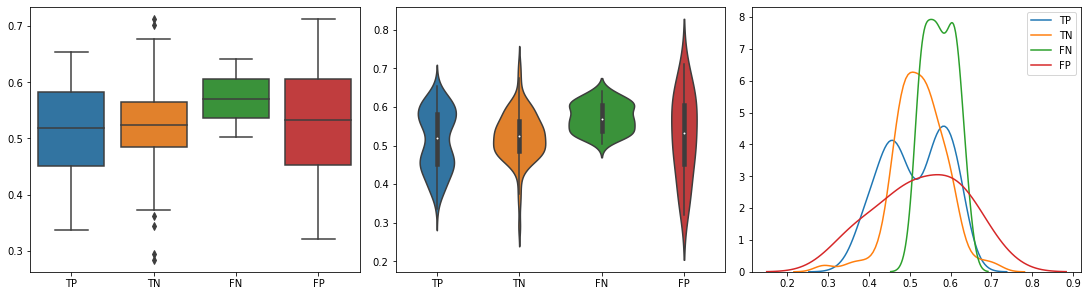

In [81]:
plots.plot_model_performance(y,pred)
plots.plot_data_distribution_groups(y, pred, score)

#### Metrics of interpretation score cross tumor regions

Segmentation of tumor is divided into 4 tumor regions. Each region shows some specific tumor tissue with different level of aggresiveness. From previous analysis we decided to skip 3 type of region for next analysis, becouse it doesnt occure in images.

In [82]:
metrics = evaluation.evaluate_method_generator(model, analyzers[0], 
                                                    image_mask_generator(ImageDataGenerator(), ImageDataGenerator()), 
                                                    X_test.shape[0], batch_size, 0)
reg1_metrics = evaluation.evaluate_method_generator(model, analyzers[0], 
                                                    image_mask_generator(ImageDataGenerator(), ImageDataGenerator()), 
                                                    X_test.shape[0], batch_size, 1)
reg2_metrics = evaluation.evaluate_method_generator(model, analyzers[0], 
                                                    image_mask_generator(ImageDataGenerator(), ImageDataGenerator()), 
                                                    X_test.shape[0], batch_size, 2)
reg4_metrics = evaluation.evaluate_method_generator(model, analyzers[0], 
                                                    image_mask_generator(ImageDataGenerator(), ImageDataGenerator()), 
                                                    X_test.shape[0], batch_size, 4)

In [83]:
(y, pred, prob, score_regt) = np.stack(np.array(list(metrics)), axis=-1) # all together
(_, _, _, score_reg1) = np.stack(np.array(list(reg1_metrics)), axis=-1) # 1 region
(_, _, _, score_reg2) = np.stack(np.array(list(reg2_metrics)), axis=-1) # 2 region
(_, _, _, score_reg4) = np.stack(np.array(list(reg4_metrics)), axis=-1) # 4 region

Analyzer performance:


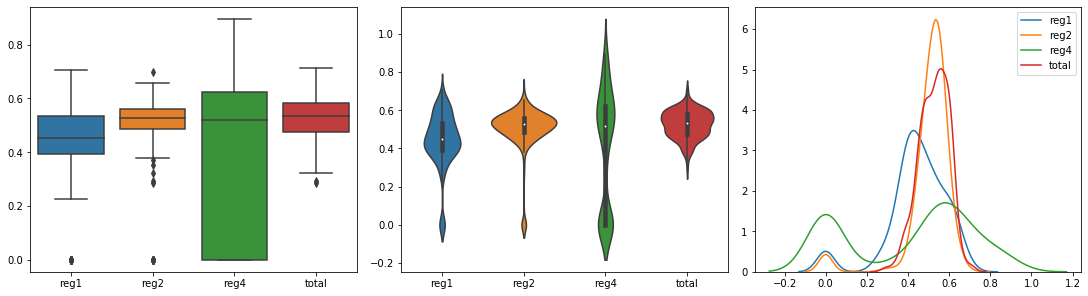

In [84]:
plots.plot_statistics_groups(scores=[score_reg1, score_reg2, score_reg4, score_regt], names=['reg1','reg2','reg4','total'])

##### Region 1

Analyzer performance:


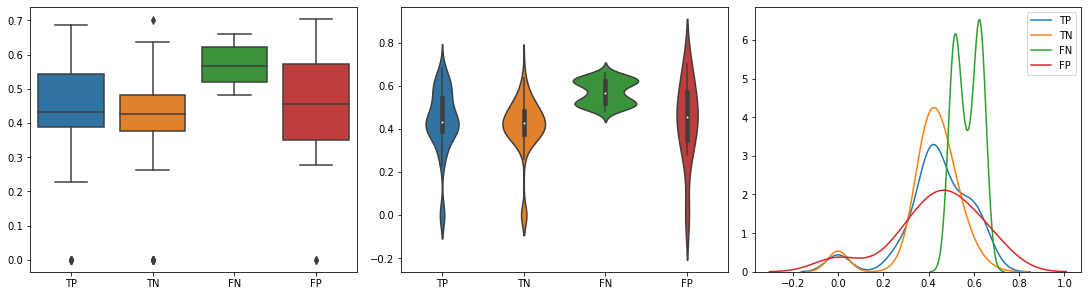

In [85]:
plots.plot_data_distribution_groups(y, pred, score_reg1)

##### Region 2

Analyzer performance:


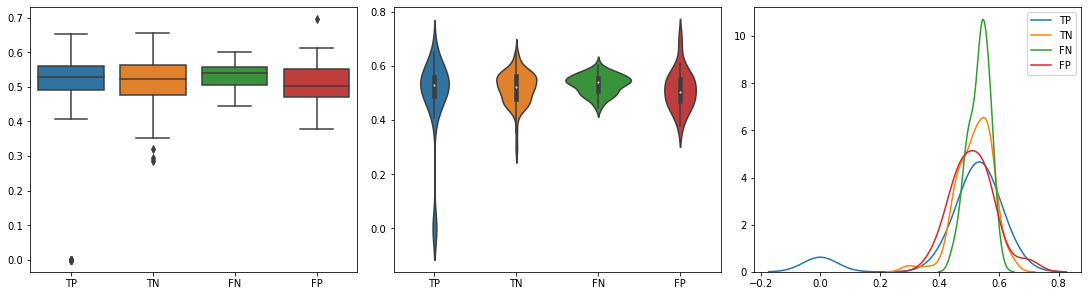

In [86]:
plots.plot_data_distribution_groups(y, pred, score_reg2)

##### Region 4

Analyzer performance:


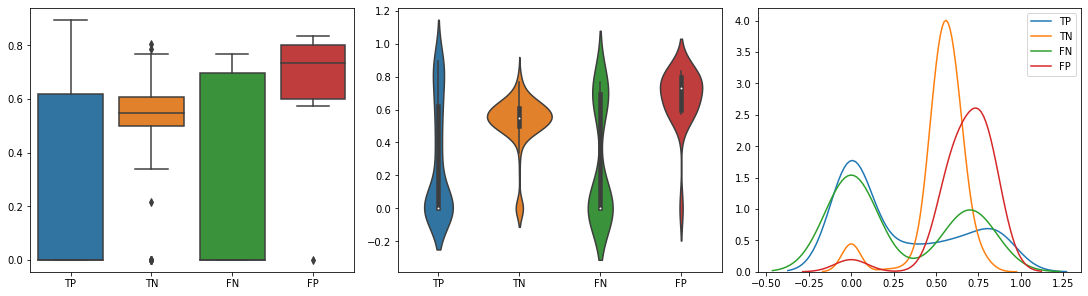

In [87]:
plots.plot_data_distribution_groups(y, pred, score_reg4)

array([[1, 1],
       [1, 0]])